# Deep Learning &mdash; Assignment 2

Second assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Implement a neural network in PyTorch;
2. Use automatic differentiation to compute gradients;
3. Experiment with SGD and Adam;
4. Experiment with hyperparameter optimization;
5. Experiment with regularization techniques.

Before we start, if PyTorch or pandas is not installed, install it now with `pip install`.

In [2]:
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install matplotlib
# !pip install tqdm

In [1]:
%config InlineBackend.figure_formats =['png']
%matplotlib inline
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import torch
import time
import torchvision
import tqdm.notebook as tqdm
import collections
import IPython
import pandas as pd

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

# Fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345);

## 2.1 Implementing a model with PyTorch

In the first assignment, you implemented a neural network from scratch in NumPy. In practice, it is more convenient to use a deep learning framework. In this course, we use [PyTorch](https://pytorch.org/).

In this example, we will use PyTorch to implement and train a simple neural network.

### PyTorch tensors

Similar to NumPy, PyTorch works with multi-dimensional tensors. These can be scalars, vectors, matrices, or have an even higher dimension.

Tensors can be created by converting NumPy arrays, or directly in PyTorch:

In [4]:
# create a 10x10 matrix filled with zeros
x = np.zeros([10, 10])
x = torch.tensor(x)
print(x)

# create a 3x5 matrix of ones
x = torch.ones([3, 5])
print(x)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


Note that the tensors have a datatype (`dtype`) that defines the type of number in the matrix. This can be 32-bit or 64-bit floating point numbers, or various types of integers. (See the [PyTorch documentation](https://pytorch.org/docs/stable/tensor_attributes.html#torch.dtype) for a complete list.)

In [5]:
print('float32:', torch.tensor([1., 2., 3.], dtype=torch.float32))
print('float64:', torch.tensor([1., 2., 3.], dtype=torch.float64))
print('int:', torch.tensor([1, 2, 3], dtype=torch.int))
print('long:', torch.tensor([1, 2, 3], dtype=torch.long))

float32: tensor([1., 2., 3.])
float64: tensor([1., 2., 3.], dtype=torch.float64)
int: tensor([1, 2, 3], dtype=torch.int32)
long: tensor([1, 2, 3])


It can be important to choose the correct datatype for your tensors, because this influences the precision, the computational cost, or the memory requirements. Some functions also specifically require integers.

### Moving data to and from the GPU

If you have a GPU, you can use it to increase the speed of PyTorch computations. To do this, you have to move your data to the GPU by calling `to('cuda')`. Afterwards, you can move the results back to the CPU by calling `to('cpu')` or `cpu()`.

Note: in MacOS you can use the `'mps'` backend instead of `'cuda'`.

In [2]:
# this only works if you have a GPU available
if torch.cuda.is_available():
    # define a variable on the CPU
    x = torch.ones((3,))
    # move the variable to the GPU
    x = x.to('cuda')
    print('x is now on the GPU:', x)
    # move the variable back to the CPU
    x = x.to('cpu')
    print('x is now on the CPU:', x)
elif torch.backends.mps.is_available():
    # define a variable on the CPU
    x = torch.ones((3,))
    # move the variable to the GPU
    x = x.to('mps')
    print('x is now on the GPU:', x)
    # move the variable back to the CPU
    x = x.to('cpu')
    print('x is now on the CPU:', x)
else:
    print('It looks like you don\'t have a GPU available.')

x is now on the GPU: tensor([1., 1., 1.], device='cuda:0')
x is now on the CPU: tensor([1., 1., 1.])


Note: If you want to run a computation on the GPU, all variables of that function should be moved to the GPU first. If some variables are still on the CPU, PyTorch will throw an error.

**If you have a GPU, make the following code run without errors.**

In [16]:
if torch.cuda.is_available():
    x = torch.tensor([1, 2, 3], device='cuda')
    y = torch.tensor([1, 2, 3], device='cuda')
    print('x is on the CPU:', x)
    print('y is on the GPU:', y)
    z = x * y
    print(z)

To use the GPU when it is available, and fall back to the CPU otherwise, a common trick is to define a global `device` constant. You can then use `tensor.to(device)` and `torch.tensor(device=device)`.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Converting back to NumPy

Sometimes, it is useful to convert PyTorch tensors back to NumPy arrays, for example, if you want to plot the performance of your network.

Call `detach().cpu().numpy()` on the tensor variable to convert the variable to NumPy:

In [18]:
x = torch.tensor(5.)
x_in_numpy = x.detach().cpu().numpy()
x_in_numpy

array(5., dtype=float32)

Note: `detach` detaches the tensor from the other computation, by among other things, removing gradient information.
`cpu` transfers the tensor from GPU to CPU if needed. Finally `numpy` converts from a pytorch tensor to a numpy array, these function very similarly, they just come from different libraries.

### Computing the gradients of a simple model

You can use the PyTorch tensors to perform computations, such as the function $y = x \cdot w + b$:

In [19]:
w = torch.tensor(2.)
b = torch.tensor(1.)
x = torch.tensor(5.)
print('w:', w)
print('b:', b)
print('x:', x)

y = x * w + b
print(y)

w: tensor(2.)
b: tensor(1.)
x: tensor(5.)
tensor(11.)


If we would like to compute the gradient for the parameters `w` and `b`, we could derive and compute them manually (as you did last week):

In [20]:
y_grad = 1
w_grad = y_grad * x
b_grad = y_grad
print('w_grad:', w_grad)
print('b_grad:', b_grad)

w_grad: tensor(5.)
b_grad: 1


This can be a lot of work, and it is easy to make mistakes. Fortunately, PyTorch (and other deep learning libraries) can compute these gradients automatically using automatic differentiation.

### Computing the gradient automatically

You can compute an automatic gradient as follows:

1. Tell PyTorch which variables need a gradient. You can do this by setting `requires_grad=True` when you define the variable.
2. Perform the computation.
3. Use the `backward()` function on the result to compute the gradients using backpropagation.
4. The `grad` property of your variables will now contain the gradient.

Have a look at this example, and compare the gradients with the gradients we computed manually:

In [21]:
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
x = torch.tensor(5.)

# compute the function
y = x * w + b

# compute the gradients, given dy = 1
y.backward()

print('w.grad:', w.grad)
print('b.grad:', b.grad)
# x did not have requires_grad, so no gradient was computed
print('x.grad:', x.grad)

w.grad: tensor(5.)
b.grad: tensor(1.)
x.grad: None


This also works for much more complicated functions (and even entire neural networks):

In [22]:
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
x = torch.tensor(5.)

y = torch.exp(torch.sin(x * w) + b)
y.backward()

print('w.grad:', w.grad)
print('b.grad:', b.grad)

w.grad: tensor(-6.6191)
b.grad: tensor(1.5777)


### Inspect the automatic differentiation history

PyTorch can compute these gradients automatically because it keeps track of the operations that generated the result.

While you don't normally need to do this, you can look inside `y.grad_fn` to see how it works:

In [23]:
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
x = torch.tensor(5.)

y = x * w + b

print('y.grad_fn:', y.grad_fn)
print('  \-->', y.grad_fn.next_functions)
print('          \-->', y.grad_fn.next_functions[0][0].next_functions)

y.grad_fn: <AddBackward0 object at 0x7f08afef3b20>
  \--> ((<MulBackward0 object at 0x7f090d847f70>, 0), (<AccumulateGrad object at 0x7f07dda2a530>, 0))
          \--> ((None, 0), (<AccumulateGrad object at 0x7f08afef3b20>, 0))


The `grad_fn` of `y` contains a tree that reflects how `y` was computed:
* the last operation was an addition (x * w) __plus__ b: `AddBackward0` knows how to compute the gradient of that;
* one of the inputs to the addition was a multiplication x __times__ w: `MulBackward0` computes the gradient;
* eventually, the backpropagation reaches the input variables: `AccumulateGrad` is used to store the gradient in the `grad` property of each variable.

As long as you use operations for which PyTorch knows the gradient, the `backward()` function can perform automatic backpropagation and the chain rule to compute the gradients. If you want, can read more about this in the [PyTorch autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

## 2.2 PyTorch neural network with torch.nn (1 point)

The `torch.nn` module of PyTorch contains a large number of building blocks to construct your own neural network architectures. You will need this in this and future assignments. Have a look at the [documentation for `torch.nn`](https://pytorch.org/docs/stable/nn.html) to see what is available. In this assignment, we will use [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) to build networks with linear layers, as well as some activation and loss functions.

### A network module

As a first example, the two-layer network from last week can be implemented like this:

In [24]:
class Week1Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = torch.nn.Linear(64, 32)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(32, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x


net = Week1Net()

Observe the following:
* A network in PyTorch is usually implemented as a subclass of `torch.nn.Module`, as it is here.
* The `__init__` function defines the layers that are used in the network.
* The `forward` function computes the output of the network given one or more inputs (in this case: `x`).

Notice that there is no final activation function (such as a sigmoid or softmax) at the end of the network. This is not a mistake: we will do this later, by using a loss function that combines the sigmoid/softmax and the loss in one computation, because this is more numerically stable.

### Network parameters

Some of the components of the network have parameters, such as the weight and bias in the Linear layers. We can list them using the `parameters` or `named_parameters` function:

In [25]:
for name, param in net.named_parameters():
    print(name)
    print(param)
    print()

layer1.weight
Parameter containing:
tensor([[ 0.1204,  0.0949,  0.1230,  ...,  0.0031,  0.0987,  0.0778],
        [-0.0368, -0.0247, -0.0457,  ...,  0.1129, -0.1046, -0.0674],
        [-0.0711,  0.0584, -0.1189,  ..., -0.0951, -0.0886, -0.1063],
        ...,
        [ 0.1221,  0.0225,  0.0512,  ...,  0.1025, -0.0922,  0.0637],
        [ 0.0418,  0.0997, -0.1024,  ...,  0.0736,  0.0114, -0.0886],
        [-0.0612, -0.1228, -0.0385,  ..., -0.0722, -0.0586,  0.0396]],
       requires_grad=True)

layer1.bias
Parameter containing:
tensor([ 0.1221, -0.0313,  0.0030,  0.1030, -0.0493,  0.1041, -0.1215,  0.1121,
         0.0570,  0.0154,  0.0428,  0.1016,  0.0611, -0.0624,  0.0602,  0.0817,
        -0.0005, -0.0573,  0.0241,  0.0720, -0.0800,  0.0652,  0.0580, -0.1215,
         0.0597,  0.1039, -0.0357,  0.0801, -0.0139,  0.0949,  0.0461,  0.0790],
       requires_grad=True)

layer2.weight
Parameter containing:
tensor([[ 0.1005, -0.0351, -0.1699,  0.0777, -0.0036,  0.0751,  0.1679,  0.1333,
  

As you can see, these parameters have been initialized to non-zero values. 

**(a) Why are these weights not zero?<span style="float:right"> (1 point)</span>**

If we initialize the network with zero weights, we could not compute reasonable gradients to search for the gradient decent, as the multiplication with an all-zero weight matrix will cause all derivatives to become zero.

### Shortcut: use `torch.nn.Sequential`

Quite often, as in our network above, a network architecture consists of a number of layers that are computed one after the other. PyTorch has a special `torch.nn.Sequential` function to quickly define these networks, without having to define a new class.

For example, the network we implemented earlier can also be written like this:

In [26]:
def build_net():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 10)
    )


net = build_net()
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)


## 2.3 A neural network for Fashion-MNIST (12 points)

In this assignment, we will do experiments with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). First, we download the dataset, and create a random training set with 1000 images and a validation set with 500 images:

In [27]:
fashionmnist = torchvision.datasets.FashionMNIST(
    root=".", download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        lambda img: img.flatten()
    ]))

# use 1000 samples for training, 500 for validation, ignore the rest
fashion_train, fashion_validation, _ = torch.utils.data.random_split(
    fashionmnist, [1000, 500, len(fashionmnist) - (1000 + 500)])

### Plot some images

The Fashion-MNIST contains images of 28 by 28 pixels, from 10 different classes. In our experiments we flatten the images to a vector with 28 x 28 = 784 features.

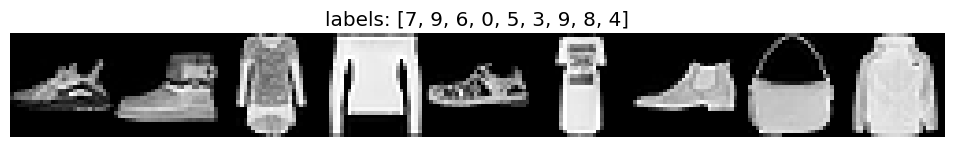

In [28]:
# plot some of the images
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([fashion_train[i][0].reshape(28, 28) for i in range(9)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')
plt.title('labels: ' + str([fashion_train[i][1] for i in range(9)]));

**(a) Can you, as a human, distinguish the different classes? Do you think a neural network should be able to learn to do this as well?<span style="float:right"> (1 point)</span>**

As a human, I can easily distinguish things like shoes, trousers, and shirts from each other, but distinguishing a shirt from a hoody, for example, is harder while still possible.
As for the numbers, I think a complex enough network can get a high accuracy, but will not reach 100%.

### Use the DataLoader to create batches

We will use the `DataLoader` from PyTorch (see the [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)) to automatically create random batches of 10 images:

In [29]:
data_loader = torch.utils.data.DataLoader(fashion_train, batch_size=10, shuffle=True)

We will use the data loader to loop over all batches in the dataset.

For each batch, we get `x`, a tensor containing the images, and `y`, containing the label for each image:

In [30]:
for x, y in data_loader:
    print('x.dtype:', x.dtype, 'x.shape:', x.shape)
    print('y.dtype:', y.dtype, '  y.shape:', y.shape)
    # one batch is enough for now
    break

x.dtype: torch.float32 x.shape: torch.Size([10, 784])
y.dtype: torch.int64   y.shape: torch.Size([10])


### Construct a network

We will construct a network that can classify these images.

**(b) Implement a network with the following architecture using `torch.nn.Sequential`:<span style="float:right"> (2 points)</span>**

* Accept flattened inputs: 28 x 28 images mean an input vector with 784 elements.
* Linear hidden layer 1, ReLU activation, output 128 features.
* Linear hidden layer 2, ReLU activation, output 64 features.
* Linear output layer, to 10 classes.
* No final activation function.

In [31]:
def build_net() -> torch.nn.Module:
    return torch.nn.Sequential(
        torch.nn.Linear(784, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10)
    )


net = build_net()
print(net)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


**(c) Test your network by creating a data loader and computing the output for one batch:<span style="float:right"> (3 points)</span>**

In [32]:
# use a data loader to loop over fashion_train,
# with a batch size of 16, shuffle the dataset
data_loader = torch.utils.data.DataLoader(fashion_train, batch_size=16, shuffle=True)

net = build_net()
for x, y in data_loader:
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
    output = net.forward(x)
    print('output.shape', output.shape)
    break

x.shape: torch.Size([16, 784])
y.shape: torch.Size([16])
output.shape torch.Size([16, 10])


### Train a network with PyTorch

To train the network, we need a number of components:
* A network, like the one you just defined.
* A [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to loop over the training samples in small batches.
* A loss function, such as the cross-entropy loss. See the [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) in the PyTorch documentation.
* An optimizer, such as SGD or Adam: after we use the `backward` function to compute the gradients, the optimizer computes and applies the updates to the weights of the network. See the [optimization algorithms](https://pytorch.org/docs/stable/optim.html) in the PyTorch documentation.

As an example, the code below implements all of these components and runs a single update step of the network.

**(d) Have a look at the code to understand how it works. Then make the following changes:<span style="float:right"> (4 points)</span>**
* Set the batch size to 16
* Use Adam as the optimizer and set the learning rate to 0.01
* For each minibatch, compute the output of the network
* Compute and optimize the cross-entropy loss

In [33]:
# initialize a new instance of the network
net = build_net()

# construct a data loader for the training set
data_loader = torch.utils.data.DataLoader(fashion_train, batch_size=16, shuffle=True)

# initialize the Adam optimizer
# we pass the list of parameters of the network
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

loss_function = torch.nn.CrossEntropyLoss()

# repeat for multiple epochs
for epoch in range(10):
    # compute the mean loss and accuracy for this epoch
    loss_sum = 0.0
    accuracy_sum = 0.0
    steps = 0

    # loop over all minibatches in the training set
    for x, y in data_loader:
        # compute the prediction given the input x
        output = net.forward(x)

        # compute the loss by comparing with the target output y
        loss = loss_function(output, y)

        # for a one-hot encoding, the output is a score for each class
        # we assign each sample to the class with the highest score
        pred_class = torch.argmax(output, dim=1)
        # compute the mean accuracy
        accuracy = torch.mean((pred_class == y).to(float))

        # reset all gradients to zero before backpropagation
        optimizer.zero_grad()
        # compute the gradient
        loss.backward()
        # use the optimizer to update the parameters
        optimizer.step()

        accuracy_sum += accuracy.detach().cpu().numpy()
        loss_sum += loss.detach().cpu().numpy()
        steps += 1

    # print('y:', y)
    # print('pred_class:', pred_class)
    # print('accuracy:', accuracy)
    print('epoch:', epoch,
          'loss:', loss_sum / steps,
          'accuracy:', accuracy_sum / steps)

epoch: 0 loss: 1.1801386555982014 accuracy: 0.5525793650793651
epoch: 1 loss: 0.7564850208305177 accuracy: 0.7103174603174603
epoch: 2 loss: 0.6169877696841483 accuracy: 0.7638888888888888
epoch: 3 loss: 0.5665754687100176 accuracy: 0.7886904761904762
epoch: 4 loss: 0.5834637322123088 accuracy: 0.8005952380952381
epoch: 5 loss: 0.5290524505433583 accuracy: 0.8214285714285714
epoch: 6 loss: 0.5228580394907604 accuracy: 0.8134920634920635
epoch: 7 loss: 0.4587841405281945 accuracy: 0.8313492063492064
epoch: 8 loss: 0.3974530810401553 accuracy: 0.8630952380952381
epoch: 9 loss: 0.4477589400041671 accuracy: 0.8601190476190477


**(e) Run the optimization for a few epochs. Does the loss go down? Has the training converged?<span style="float:right"> (1 point)</span>**

Yes, the loss decreased, while the accuracy converged from epoch 6 onwards to around 84 %.

**(f) Looking back at the network, we did not include a SoftMax activation function after the last linear layer. But typically you need to use a softmax activation when using cross-entropy loss. Was there a mistake?<span style="float:right"> (1 point)</span>**

Hint: Look at the documentation of the cross-entropy loss function. Is the formula there the same as in the slides?

The formula in the documentation shows that it already combines the Categorical CBE loss and the softmax activation function, as we have learned it in the lecture

**(optional) Why do you think the developers of PyTorch did it this way?**

Probably because of efficiency and/or numerical stability for the floating point arithmetic.

## 2.4 Training code for the rest of this assignment

For the rest of this assignment, we will use a slightly more advanced training function. It runs the training loop for multiple epochs, and at the end of each epoch evaluates the network on the validation set.

Feel free to look inside, but keep in mind that some of this code is only needed to generate the plots in this assignment.

In [ ]:
# helper code to plot our results
class HistoryPlotter:
    def __init__(self, plots, table, rows, cols):
        self.plots = plots
        self.table = table
        self.rows = rows
        self.cols = cols
        self.histories = {}
        self.results = []

        self.fig, self.axs = plt.subplots(ncols=cols * len(plots), nrows=rows,
                                          sharex='col', sharey='none',
                                          figsize=(3.5 * cols * len(plots), 3 * rows))
        plt.tight_layout()
        IPython.display.display(self.fig)
        IPython.display.clear_output(wait=True)

    # add the results of an experiment to the plot
    def add(self, title, history, row, col):
        self.histories[title] = history
        self.results.append((title, {key: history[key][-1] for key in self.table}))

        for plot_idx, plot_xy in enumerate(self.plots):
            ax = self.axs[row, col * len(self.plots) + plot_idx]
            for key in plot_xy['y']:
                ax.plot(history[plot_xy['x']], history[key], label=key)
            if 'accuracy' in plot_xy['y'][0]:
                ax.set_ylim([0, 1.01])
            ax.legend()
            ax.set_xlabel(plot_xy['x'])
            ax.set_title(title)
        plt.tight_layout()
        IPython.display.clear_output(wait=True)
        IPython.display.display(self.fig)

    # print a table of the results for all experiments
    def print_table(self):
        df = pd.DataFrame([
            {'experiment': title, **{key: row[key] for key in self.table}}
            for title, row in self.results
        ])
        IPython.display.display(df)

    def done(self):
        plt.close()
        self.print_table()

As you can see, not every combination of hyperparameters works equally well.

**(b) Was 150 epochs long enough to train the network with all settings? List the experiments that have/have not yet converged.<span style="float:right"> (2 points)</span>**

**(d) A larger learning rate does not always lead to better or faster training. What happened to Adam with a learning rate of 0.1?<span style="float:right"> (1 point)</span>**

### Same accuracy, increasing loss

You may have noticed something interesting in the curves for "Adam lr=0.001": after 10 to 20 epochs, the loss on the validation set starts increasing again, while the accuracy remains the same. How is this possible?

We can find a clue by looking at the output of the network. We will plot the final outputs: the prediction just before the softmax activation function. These values are also called 'logits'.

**(f) Run the code below to generate the plots.**

### Minibatch size

Another important hyperparameter is the minibatch size. Sometimes your minibatch size is limited by the available memory in your GPU, but you can often choose different values.

We will run an experiment to train our network with different minibatch sizes:
* Minibatch size: 4, 16, 32, 64

We will fix the other hyperparameters to values that worked well in the previous experiment:
* Optimizer: Adam
* Learning rate: 0.0001
* 150 epochs

For each setting, we will plot:
* The train and validation accuracy vs number of epochs
* The train and validation loss vs number of epochs
* The train and validation accuracy vs the number of gradient descent update steps
* The train and validation accuracy vs the training time

We will also print a table with the results of the final epoch.

**(h) Run the experiment and have a look at the results.**

**(j) What are the effects of making the minibatches very small?<span style="float:right"> (1 point)</span>**

## 2.6 Regularization (13 points)

Besides choosing the hyperparameters, we can include other components to improve the training of the model.

In this section, we will experiment with batch normalization, weight decay, and data augmentation.

### Batch normalization

Batch normalization can be implemented with the batch normalization modules from `torch.nn` [(documentation)](https://pytorch.org/docs/stable/nn.html#normalization-layers).

For a network with 1D feature vectors, you can use `torch.nn.BatchNorm1d` [(documentation)](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d).

**(a) Construct a network with batch normalization:<span style="float:right"> (1 point)</span>**

Use the same structure as before, but include batchnorm after the hidden linear layers. So we have:
* A linear layer from 784 to 128 features, followed by batchnorm and a ReLU activation.
* A linear layer from 128 to 64 features, followd by batchnorm and ReLU activation.
* A final linear layer from 64 features to 10 outputs, no activation.

**(c) Does batch normalization improve the performance of the network?<span style="float:right"> (1 point)</span>**

Let us look a bit closer at how batch normalization changes the network.

We will plot some statistics about the values inside the network.

We make similar plots for the network with batch normalization: (Note that the number of layers is slightly larger.)

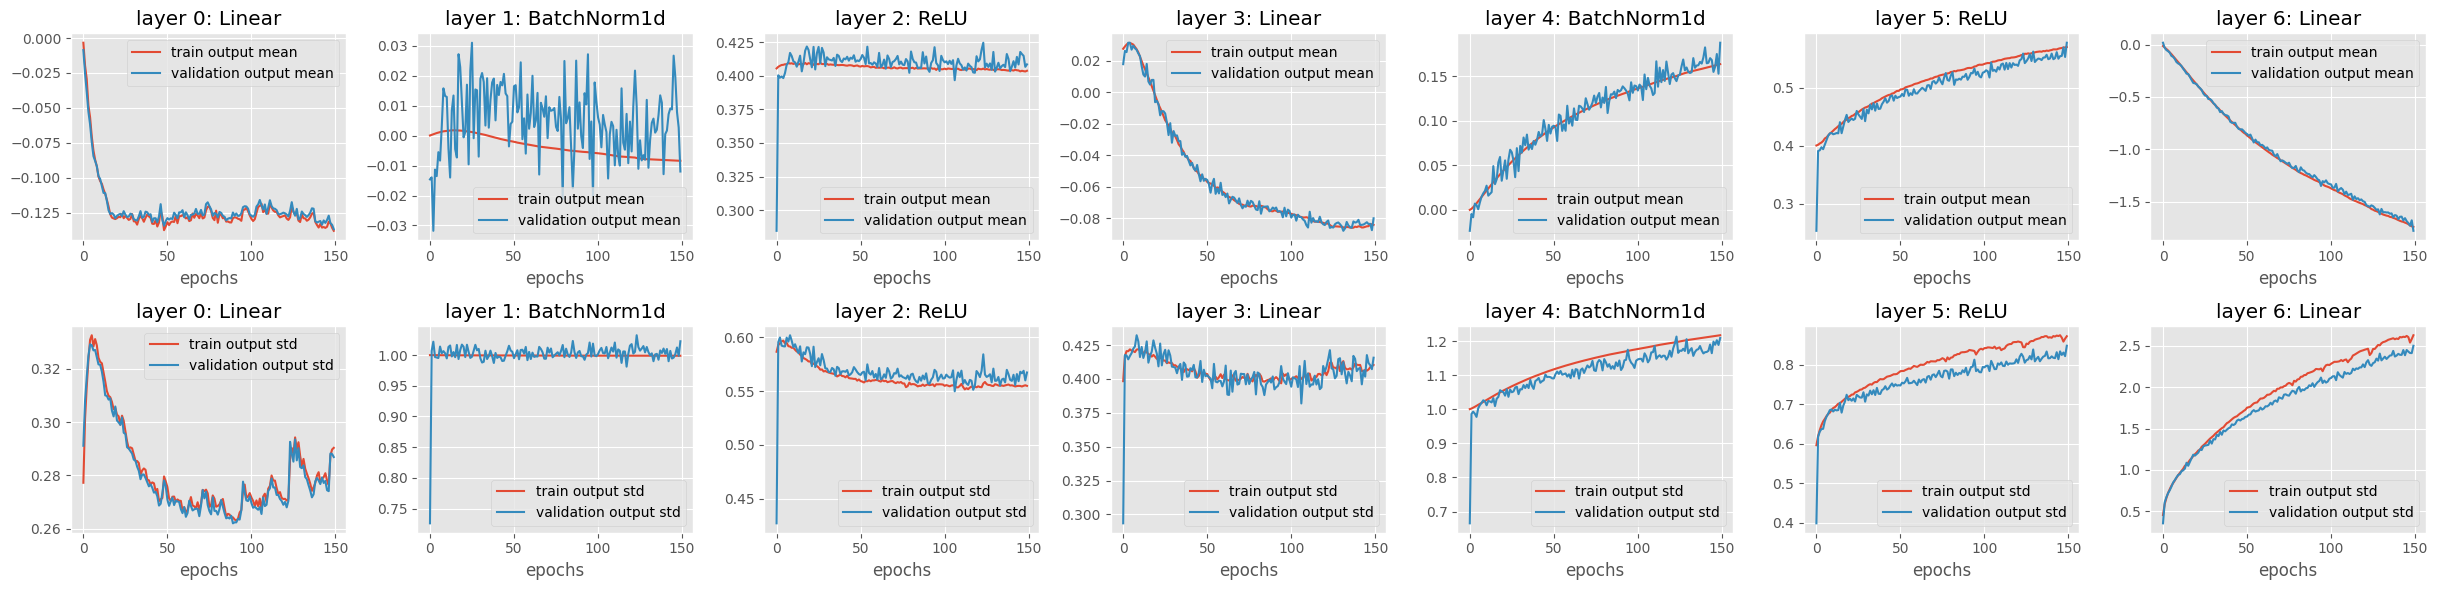

In [33]:
plot_layer_stats(7, histories['with batchnorm'])

In the network without normalization, we can see that the mean and standard deviation continuously grow, except for the last layer. On the other hand, in the network with batch normalization, we can observe that layer 1 and 4, those are the normalization layers, try to smooth the train output to a mean of 0 and a standard deviation of 1. As a consequence, the validation output is also in the same area.
This also leads to a smaller change in the mean and std deviation of the other layers.

**(f) Compare the train and validation curves for the batch normalization layers. The training curves are smooth, but the validation curve is noisy. Why does this happen?<span style="float:right"> (1 point)</span>**

**(g) Batch normalization is supposed to normalize the values to $\mu = 0$ and $\sigma = 1$, but in layer 4, the mean and standard deviation are steadily increasing over time. Why and how does this happen?<span style="float:right"> (1 point)</span>**

This is because the normalization layer has two values $\beta$ and $\gamma$, which are learnable, i.e., adopted during the backpropagation. This values put an offset to the mean ($\beta$) and scale the std deviation ($\gamma$).

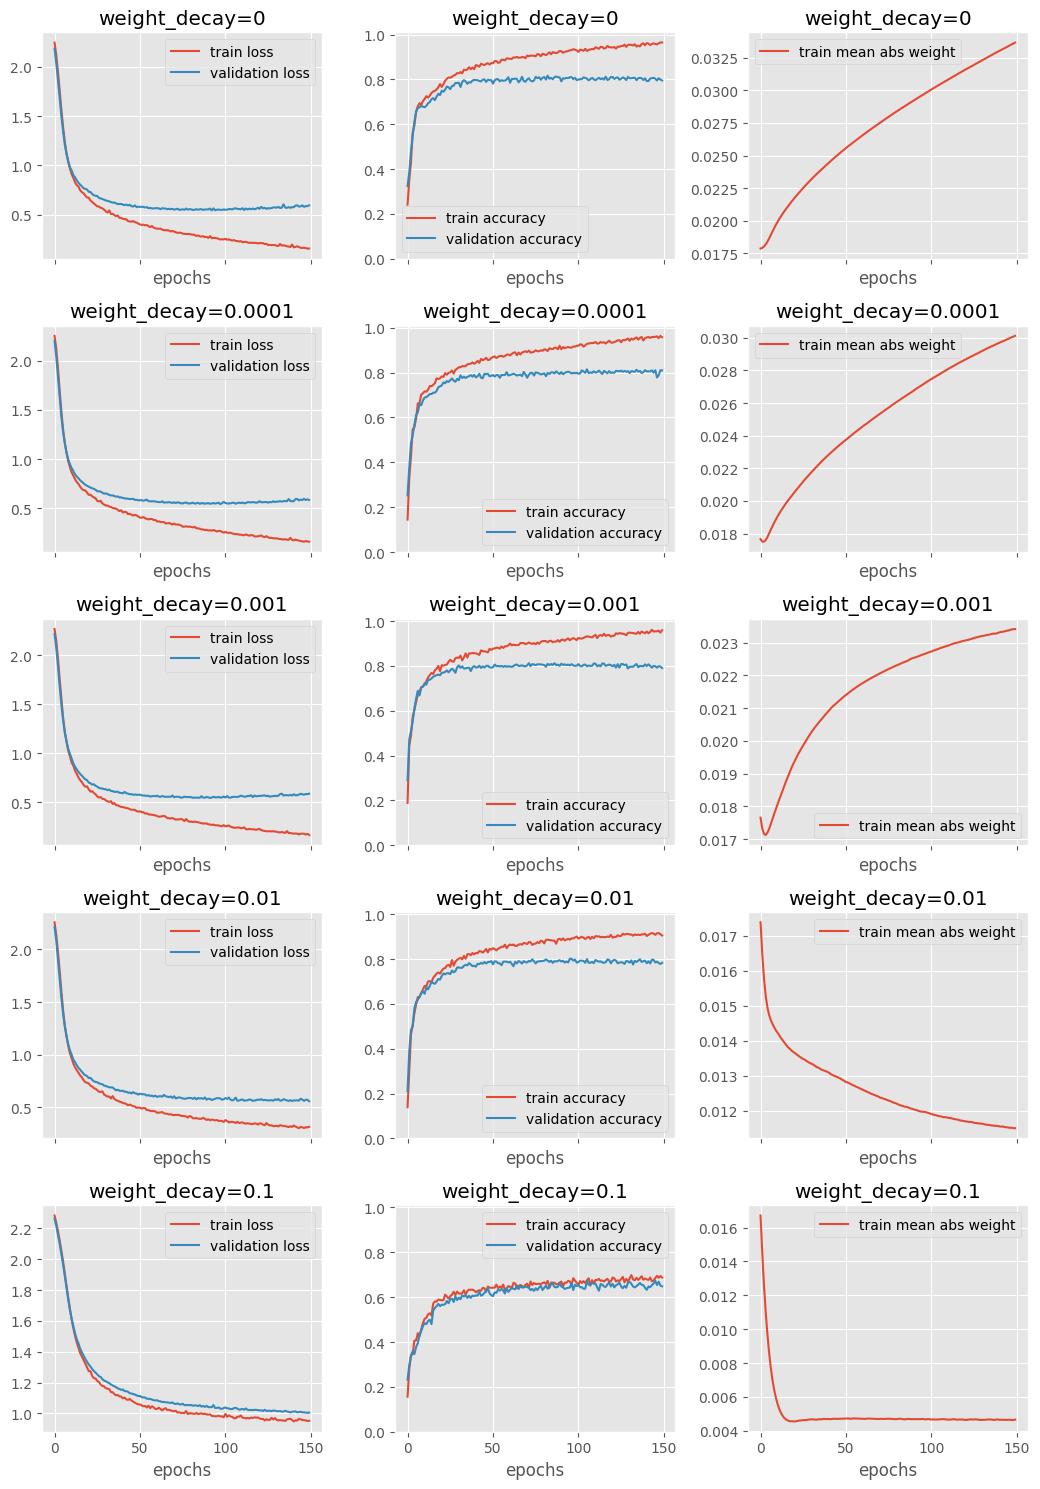

,experiment,train accuracy,validation accuracy,train mean abs weight
0,weight_decay=0,0.964844,0.795312,0.033657
1,weight_decay=0.0001,0.958008,0.809766,0.030113
2,weight_decay=0.001,0.958984,0.790234,0.023411
3,weight_decay=0.01,0.905273,0.783594,0.011496
4,weight_decay=0.1,0.687500,0.648438,0.004659


In [34]:
plotter = HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                                {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},
                                {'x': 'epochs', 'y': ['train mean abs weight']}, ],
                         table=['train accuracy', 'validation accuracy', 'train mean abs weight'],
                         rows=5, cols=1)

epochs = 150
lr = 0.0001
batch_size = 32
weight_decays = [0, 0.0001, 0.001, 0.01, 0.1]

for row, weight_decay in enumerate(weight_decays):
    net = build_net()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    history = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter.add('weight_decay=%s' % str(weight_decay), history, row=row, col=0)

plotter.done()

**(i) How can you observe the amount of overfitting in the plots? <span style="float:right"> (1 point)</span>**

**(j) How does weight decay affect the performance of the model in the above experiments? Give an explanation in terms of the amount of overfitting. <span style="float:right"> (1 point)</span>**

For a weight decay of 0.0001, 0.001, and 0.01, the weight decay reduces the difference in the training and validation loss with only a small harm in the validation accuracy. If the weight decay is too big, i.e., 0.1 in this case, the difference between the training and validation loss gets even smaller, but the accuracy of the network goes down dramatically.

In [35]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, ds, noise_sigma=0, flip_horizontal=False, shift=False):
        self.ds = ds
        self.noise_sigma = noise_sigma
        self.flip_horizontal = flip_horizontal
        self.shift = shift

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        x, y = self.ds[idx]
        # add random noise
        x = x + self.noise_sigma * torch.randn(x.shape)
        # flip the pixels horizontally with probability 0.5
        if self.flip_horizontal and torch.rand(1) > 0.5:
            x = torch.flip(x.reshape(28, 28), dims=(1,)).flatten()
        # shift the image by one pixel in the horizontal or vertical directions
        if self.shift:
            x = x.reshape(28, 28)
            # shift max one pixel
            shifts = [*torch.randint(-1, 2, (2,)).numpy()]
            x = torch.roll(x, shifts=shifts, dims=(0, 1))
            x = x.flatten()
        return x, y

We set up an experiment to see if data augmentation improves our results. We use combinations of the three augmentations: noise, flipping, and shifting.

We will train for 250 epochs.

We keep the other settings as before:
* Optimizer: Adam
* Learning rate: 0.0001
* Minibatch size: 32

**(k) Run the experiment and have a look at the results.**

**(l) How does data augmentation affect overfitting in the above experiment? Discuss each of the augmentation types.<span style="float:right"> (3 points)</span>**

*Adding noise:*
Noise has only a limited effect on the overfitting prevention, but it does have a small effect on generalization, i.e., the validation loss gets closer to training loss.

*Horizontal flips:*
Horizontal flips seem to affect the overfitting as well, but only with a small effect.

*Shifting:*
Shifting has by far the biggest effect on overfitting prevention in this experiment and reduces the difference between the validation and training curves in both, the accuracy and loss.

Combining all the methods seems to lead to the best results in regard to overfitting and even improves the validation accuracy.

Because modifying the data takes time as well.

## 2.7 Network architecture (5 points)

An often overlooked hyperparameter is the architecture of the neural network itself. Here you can think about the width (the size of each hidden layer) or the depth (the number of layers).

In [37]:
def build_net(width=128):
    return torch.nn.Sequential(
        torch.nn.Linear(784, width),
        torch.nn.ReLU(),
        torch.nn.Linear(width, width // 2),
        torch.nn.ReLU(),
        torch.nn.Linear(width // 2, 10)
    )

**(b) Set up an experiment to see how the size of the network affects our results. <span style="float:right"> (1 point)</span>**

We keep the other settings as before:
* Optimizer: Adam
* Epochs: 150
* Learning rate: 0.0001
* Minibatch size: 32
* Widths: 16, 32, 64, 128, 256, 512

**(c) For what network sizes do you observe underfitting? <span style="float:right"> (1 point)</span>**

The 16-neuron network is underfitting, which we can see in a not as good validation accuracy. The 32-neuron network does slightly underfit as well.

**(d) Do you see overfitting for the largest networks? How can you see this from the plots? <span style="float:right"> (1 point)</span>**

The 256-neuron and 512-neuron networks are clearly overfitting, which we can see at a decreasing training loss while the validation loss goes up a lot.
The 128-neuron network seems to slightly overfit as well.

**(e) How many parameters are there in a network with width 128? How does that compare to the number of training samples?<span style="float:right"> (1 point)</span>**

You don't have to give an exact value, as long as you are in the right order of magnitude, it is okay.

(Feel free to write some python code to do computations.)

In [39]:
def network_size(size):
    weights_layer1 = 784 * size
    biases_layer1 = size
    weights_layer2 = size * (size // 2)
    biases_layer2 = size // 2
    weights_layer3 = (size // 2) * 10
    biases_layer3 = 10
    return weights_layer1 + biases_layer1 + weights_layer2 + biases_layer2 + weights_layer3 + biases_layer3

print("Network params", network_size(128))

print("Data set", len(fashionmnist))

print("Network params / Data set size", network_size(128) / len(fashionmnist))

Network params 109386
Data set 60000
Network params / Data set size 1.8231


The network, with a width of 128, has about 110,000 parameters, while we have only 60,000 samples. This means that we have around 1.8 as many parameters than examples, of which we use only a part for the training and another part only for validation.

## 2.8 Discussion (3 points)

**(a) Several of the experiments have included a baseline with exactly the same hyperparameters (batch_size=32, weight_decay=0, network_size=128). Are the results exactly the same? What does this tell you about comparing results for picking the best hyperparameters?<span style="float:right"> (2 points)</span>**

No, they are not exactly the same, as there is a lot of randomness included. For example, the weight initialization for the linear layers, and the shuffling of the training data. This means that a slight change in the network performance might not be due to a change in the hyperparameters, but just because of the randomness. Therefore, only significant changes in the network performance are relevant to choosing the hyperparameters.

**(b) Throughout this assignment we have used a validation set of 500 samples for selecting hyperparameters. Do you think that you will see the same results on an independent test set? Would the best results be obtained with the hyperparameters that are optimal on the validation set? <span style="float:right"> (1 point)</span>**

The results of the independent test set probably differ a bit from the validation set. Similarly, the best hyperparameters for the validation set might not be the same as for the independent test set. Still, we do not want to optimize our model for the test set, as it would bias the prediction on how good the network performs on real-world data.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 44 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version d4d27c6 / 2023-09-08</span>